<div >
    <h1 style="width:100%">Exploring the Influence of Socioeconomic Factors on Small Area Mental Health Index Across Spatial Patterns</h1>
    <h3 style="width:600px">Author: Zuqi Dong</h3>
</div>


*This is the assignment for the UCL CASA module Data Science for Spatial Systems (CASA0006)*
<br>
**Code and Data is hosted [here](https://github.com/Ddddzq/casa0006/tree/main)**<br>
Link to the original raw data can be found in the  [Appendix](#ID_app)

<a id="ID_itr"></a>
| [Intro](#ID_itr) | [Literature review](#ID_litr) | [Data](#ID_d) | [Analysis](#ID_an) | [Discussion and conclusion](#ID_d&c) | [Bibliography](#ID_bib) | [Appendix](#ID_app) |

## Introduction

Various socioeconomic factors influence mental health disparities and are a significant public health concern. To better understand and address these disparities, this study poses the following research question: How do socioeconomic factors influence mental health outcomes across different spatial patterns, and what are the most influential factors affecting mental health within different mental health levels as classified by threshold values based on the Small Area Mental Health Index (SAMHI) scores?

This research aims to explore the complex relationships between mental health outcomes and socioeconomic factors across different geographic areas by employing multiple regression, spatial analysis, and machine learning techniques, specifically the Random Forest algorithm. The findings will contribute to the existing body of knowledge on mental health disparities and provide valuable insights for policymakers and practitioners working to address mental health inequalities at the local and regional levels.

<a id="ID_litr"></a>
| [Intro](#ID_itr) | [Literature review](#ID_litr) | [Data](#ID_d) | [Analysis](#ID_an) | [Discussion and conclusion](#ID_d&c) | [Bibliography](#ID_bib) | [Appendix](#ID_app) |

## Literature review 

#### Socioeconomic Factors and Mental Health:
A considerable body of research has demonstrated that socioeconomic factors are significant determinants of mental health outcomes. Lower socioeconomic status has been consistently associated with a higher prevalence of mental disorders, such as depression and anxiety (Yu and Williams, 1999). Key socioeconomic factors affecting mental health include income, employment, education, and social support (Fone et al., 2013).

#### Spatial Patterns in Mental Health:
Spatial analysis has emerged as an essential tool for understanding mental health disparities across geographical areas. A growing body of research highlights the importance of considering spatial patterns in mental health studies (Moscone and Knapp, 2005). Spatial patterns can reveal variations in mental health outcomes and their associated factors, which can inform targeted interventions. 

#### Machine Learning in Mental Health Research:
Machine learning algorithms, such as Random Forest, have been increasingly used in mental health research to analyse complex relationships between multiple factors and outcomes (Shatte, Hutchinson and Teague, 2019). Random Forest is an ensemble learning method that constructs multiple decision trees to improve predictive accuracy and reduce overfitting (Zhou, 2021). This algorithm is particularly useful for analysing high-dimensional and non-linear data, making it suitable for examining the intricate relationships between mental health outcomes and numerous socioeconomic factors.

#### Justification for Using Random Forest:
Random Forest can be applied to this research as it offers several advantages over traditional statistical methods, such as multiple regression. It can handle non-linear relationships, automatically select important features, and provide robust predictions even in the presence of noise or outliers (Mylona et al., 2021). By training a Random Forest model for each mental health level (based on threshold values), researchers can identify the most influential features affecting mental health within each group, providing valuable insights for targeted interventions.

<a id="ID_d"></a>
| [Intro](#ID_itr) | [Literature review](#ID_litr) | [Data](#ID_d) | [Analysis](#ID_an) | [Discussion and conclusion](#ID_d&c) | [Bibliography](#ID_bib) | [Appendix](#ID_app) |

## Data

In [27]:
import geopandas as gpd
import pandas as pd
import numpy as np
import re
import pysal as ps
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import plotly.express as px
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

### LSOA Boundary Dataset:
The LSOA boundary dataset provides the geographic boundaries of LSOAs in England based on the 2011 Census. This dataset is essential for conducting spatial analysis and visualizing the spatial patterns of mental health outcomes and socioeconomic factors across different areas. The LSOA boundary dataset will be used in conjunction with the SAMHI and IoD2019 datasets to create maps that display mental health index scores, deprivation levels, and the results of the multiple regression and Random Forest analyses.

In [18]:
#have tried to use git LFS cause this file is too large but it's not free, so read the file directly
url = 'https://borders.ukdataservice.ac.uk/ukborders/easy_download/prebuilt/shape/infuse_lsoa_lyr_2011.zip' 
! wget $url

--2023-04-06 23:51:23--  https://borders.ukdataservice.ac.uk/ukborders/easy_download/prebuilt/shape/infuse_lsoa_lyr_2011.zip
Resolving borders.ukdataservice.ac.uk (borders.ukdataservice.ac.uk)... 155.245.130.94
Connecting to borders.ukdataservice.ac.uk (borders.ukdataservice.ac.uk)|155.245.130.94|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 311956022 (298M) [application/zip]
Saving to: ‘infuse_lsoa_lyr_2011.zip’

infuse_lsoa_lyr_201 100%[===================>] 297.50M  1.82MB/s    in 2m 49s  

2023-04-06 23:54:13 (1.76 MB/s) - ‘infuse_lsoa_lyr_2011.zip’ saved [311956022/311956022]



In [2]:
# Use the `read_file` function from geopandas to read the shapefile directly from the ZIP file
gdf = gpd.read_file('zip://infuse_lsoa_lyr_2011.zip!infuse_lsoa_lyr_2011.shp')
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 42619 entries, 0 to 42618
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   geo_code    42619 non-null  object  
 1   geo_label   42619 non-null  object  
 2   geo_labelw  6976 non-null   object  
 3   label       42619 non-null  object  
 4   name        42619 non-null  object  
 5   geometry    42619 non-null  geometry
dtypes: geometry(1), object(5)
memory usage: 2.0+ MB


In [3]:
#only keep two columns for merging and visulization
gdf = gdf[['geo_code','geometry']]

### Small Area Mental Health Index (SAMHI) Dataset:
The SAMHI dataset provides information on the mental health status of small areas in England for the period between 2011 and 2019. The dataset includes a composite index score for each Lower-layer Super Output Area (LSOA) derived from various mental health-related indicators such as antidepressant prescription rates, suicide rates, and self-harm hospital admissions. The SAMHI score serves as the dependent variable in this research, representing the mental health outcome.

In [4]:
samhi = pd.read_csv ('https://raw.githubusercontent.com/Ddddzq/casa0006/main/samhi_2011_2019_LSOA.csv')
samhi.head()

,lsoa11,samhi_index.2011,samhi_dec.2011,samhi_index.2012,samhi_dec.2012,samhi_index.2013,samhi_dec.2013,samhi_index.2014,samhi_dec.2014,samhi_index.2015,samhi_dec.2015,samhi_index.2016,samhi_dec.2016,samhi_index.2017,samhi_dec.2017,samhi_index.2018,samhi_dec.2018,samhi_index.2019,samhi_dec.2019
0,E01000001,-1.733070,1,-1.665014,1,-1.729767,1,-1.460658,1,-1.428309,1,-1.507283,1,-1.326553,1,-1.371607,1,-1.183468,1
1,E01000002,-1.704465,1,-1.719869,1,-1.783252,1,-1.749144,1,-1.531450,1,-1.456034,1,-1.383528,1,-1.242643,1,-1.189840,1
2,E01000003,-0.920870,4,-0.686420,5,-0.357678,7,-0.571222,4,-0.567158,4,-0.574356,3,-0.504734,2,-0.501422,2,-0.580351,1
3,E01000005,-1.218240,2,-1.262426,2,-0.951074,3,-0.720833,4,-1.016268,2,-0.679462,2,-0.805106,1,-0.695488,1,-0.897460,1
4,E01000006,-1.892813,1,-1.837497,1,-1.784586,1,-1.724196,1,-1.630328,1,-1.537457,1,-1.352359,1,-1.452954,1,-1.237533,1


In [5]:
#only keep the 2019 index cause the deprivation data is from 2019
samhi = samhi[['lsoa11','samhi_index.2019']]
samhi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32844 entries, 0 to 32843
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   lsoa11            32844 non-null  object 
 1   samhi_index.2019  32844 non-null  float64
dtypes: float64(1), object(1)
memory usage: 513.3+ KB


### English Indices of Deprivation 2019 (IoD2019) Dataset:
The IoD2019 dataset offers a comprehensive assessment of multiple dimensions of deprivation in England at the LSOA level. In this research, we will use the data from File 2 of the IoD2019 dataset, which contains ranks for various deprivation domains, such as Income, Employment, Education, Health, Crime, Barriers to Housing and Services, and Living Environment. These ranks represent the independent variables in the study, capturing different aspects of socioeconomic factors that may influence mental health outcomes.

In [6]:
dep = pd.read_csv ('https://raw.githubusercontent.com/Ddddzq/casa0006/main/2019_Domains_of_Deprivation.csv',low_memory=False)
dep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32844 entries, 0 to 32843
Data columns (total 20 columns):
 #   Column                                                                              Non-Null Count  Dtype 
---  ------                                                                              --------------  ----- 
 0   LSOA code (2011)                                                                    32844 non-null  object
 1   LSOA name (2011)                                                                    32844 non-null  object
 2   Local Authority District code (2019)                                                32844 non-null  object
 3   Local Authority District name (2019)                                                32844 non-null  object
 4   Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)                 32844 non-null  object
 5   Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)  32844 non-null  in

In [7]:
#only keep lsoa code and seven ranks
dep = dep[['LSOA code (2011)','Income Rank (where 1 is most deprived)', 'Employment Rank (where 1 is most deprived)',
          'Education, Skills and Training Rank (where 1 is most deprived)','Health Deprivation and Disability Rank (where 1 is most deprived)',
          'Crime Rank (where 1 is most deprived)','Barriers to Housing and Services Rank (where 1 is most deprived)','Living Environment Rank (where 1 is most deprived)']]

#define a function to rename the columns
def remove_text(column_name):
    pattern = r'\s*\(where 1 is most deprived\)'
    return re.sub(pattern, '', column_name)

dep.columns = [remove_text(col) for col in dep.columns]

dep.head()

,LSOA code (2011),Income Rank,Employment Rank,"Education, Skills and Training Rank",Health Deprivation and Disability Rank,Crime Rank,Barriers to Housing and Services Rank,Living Environment Rank
0,E01000001,"32,831","32,742","32,842","32,113","32,662","7,319","7,789"
1,E01000002,"29,901","31,190","32,832","29,705","32,789","11,707","13,070"
2,E01000003,"18,510","15,103","26,386","17,600","29,363","2,157","4,092"
3,E01000005,"6,029","7,833","12,370","17,907","31,059","2,217","9,397"
4,E01000006,"14,023","21,692","17,511","21,581","18,848","1,033","10,629"


In [8]:
# Convert all rank columns to int64
for col in dep.columns[1:]:
    dep[col] = dep[col].str.replace(',', '').astype('int64')

# Check the results
dep.dtypes

LSOA code (2011)                          object
Income Rank                                int64
Employment Rank                            int64
Education, Skills and Training Rank        int64
Health Deprivation and Disability Rank     int64
Crime Rank                                 int64
Barriers to Housing and Services Rank      int64
Living Environment Rank                    int64
dtype: object

### Merge three datasets

In [9]:
# inner merge cause only wants England
eng = pd.merge(gdf, samhi, left_on='geo_code', right_on='lsoa11', how='inner')
eng = pd.merge(eng, dep, left_on='lsoa11', right_on='LSOA code (2011)',how='inner')
eng.drop(columns=['lsoa11','LSOA code (2011)'],inplace=True)
eng.shape

(32844, 10)

In [10]:
eng.head()

,geo_code,geometry,samhi_index.2019,Income Rank,Employment Rank,"Education, Skills and Training Rank",Health Deprivation and Disability Rank,Crime Rank,Barriers to Housing and Services Rank,Living Environment Rank
0,E01003513,"POLYGON ((541893.189 181249.621, 541900.568 18...",-1.270914,14743,21471,20218,21616,10270,40,14996
1,E01031647,"POLYGON ((518376.682 132574.695, 518375.785 13...",1.359390,16598,12686,23319,18258,26419,13212,30699
2,E01022006,"POLYGON ((623754.716 231042.037, 623759.750 23...",1.723523,4416,5604,3127,8732,9262,25643,23570
3,E01001159,"POLYGON ((532233.977 170474.976, 532229.824 17...",-0.810309,17482,23608,25298,25792,13747,3759,14104
4,E01008088,"POLYGON ((433539.233 392096.845, 433539.125 39...",0.920342,13557,11723,12167,10596,1980,27511,16293


<a id="ID_an"></a>
| [Intro](#ID_itr) | [Literature review](#ID_litr) | [Data](#ID_d) | [Analysis](#ID_an) | [Discussion and conclusion](#ID_d&c) | [Bibliography](#ID_bib) | [Appendix](#ID_app) |

## Analysis

### SAMHI Distribution Map

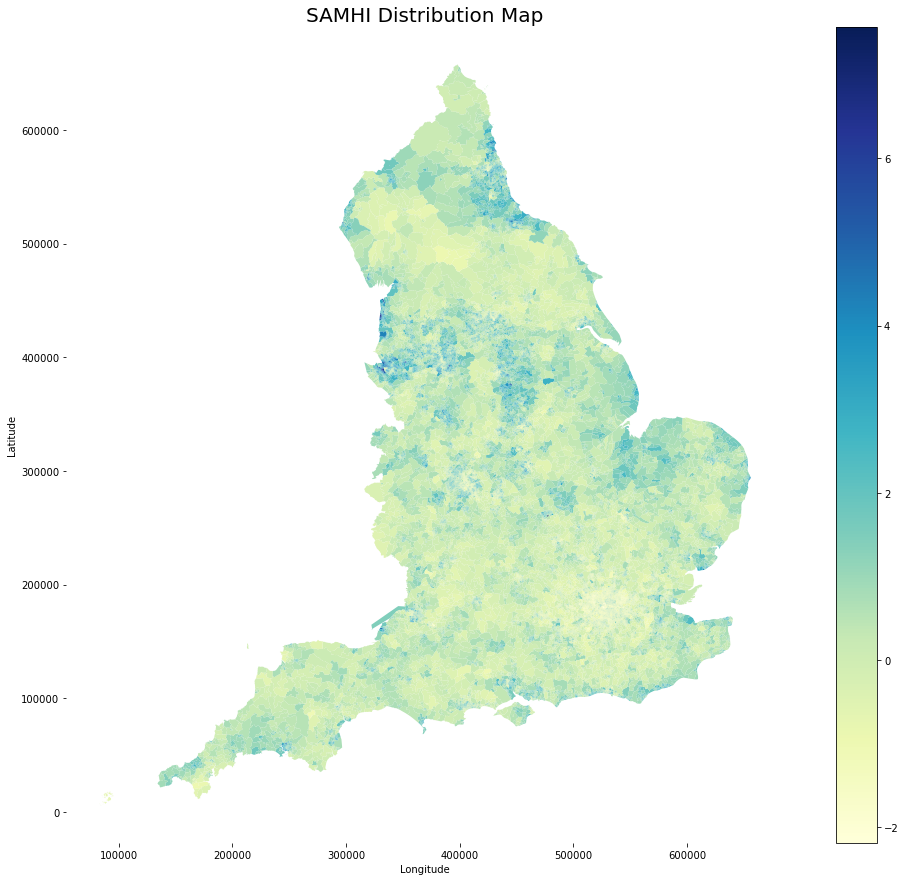

In [13]:
fig, ax = plt.subplots(figsize=(19, 15))

# Plot the map using the 'magma' colormap and the SAMHI scores as the column for coloring
eng.plot(column='samhi_index.2019', cmap='YlGnBu', legend=True, ax=ax)

# Add title and axis labels
ax.set_title('SAMHI Distribution Map', fontsize=20)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Remove the box around the map
ax.set_frame_on(False)


# Display the map
plt.show()

#plt.savefig('samhi_distribution.png', dpi=150)

The SAMHI distribution map covers the whole of England, yellow indicates lower SAMHI scores (better mental health), green represents intermediate SAMHI scores, and blue corresponds to higher SAMHI scores (worse mental health). From the map, we can see that the SAMHI Index values are generally higher in the north of England, particularly in the North East, North West, and Yorkshire and the Humber regions. On the other hand, the SAMHI Index values are generally lower in the south of England, particularly in London and the South East region.

This pattern suggests that there are regional disparities in social and economic deprivation across England. The higher SAMHI Index values in the north may indicate that these regions are facing greater challenges in terms of income, employment, education, health, crime, and access to housing and services compared to the south.

It is worth noting that the map displays the SAMHI Index values at the Lower Super Output Area (LSOA) level, which is a small geographic unit used for statistical purposes. Therefore, the map provides a detailed view of the spatial pattern of deprivation across England, but it may not capture the full complexity of the social and economic factors that contribute to deprivation in different regions.

### Correlation Matrix

Text(0.5, 1.0, 'Correlation Matrix')

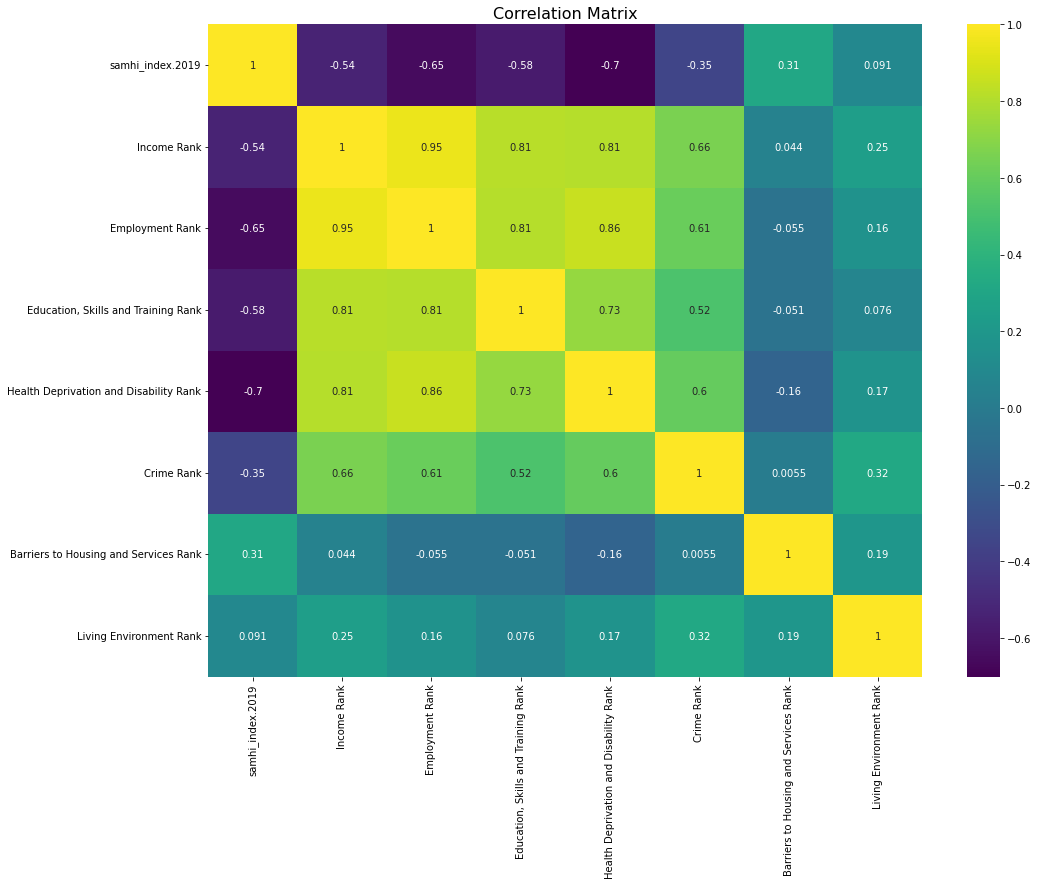

In [14]:
df = eng.drop(columns=['geo_code','geometry'])
f = plt.figure(figsize=(16, 12))
sn.heatmap(df.corr(),annot=True,cmap='viridis')
plt.title('Correlation Matrix', fontsize=16)

The correlations between SAMHI and the seven rank variables range from -0.70 to 0.091. Most of the correlations are negative, indicating that as the rank of these variables improves (higher rank values correspond to lower deprivation), the SAMHI scores tend to decrease, suggesting better mental health. The strongest negative correlation is between SAMHI and the health deprivation and disability rank (-0.70), while the weakest negative correlation is between SAMHI and the crime rank (-0.35). The positive correlations between SAMHI and the last two rank variables (0.31 and 0.091) are relatively weak, indicating little to no linear relationship between SAMHI and these variables.

The Income Rank variable and the Employment Rank variable both show strong positive correlations with Education, Skills and Training Rank, and Health Deprivation and Disablility Rank, as well as a moderately strong positive correlation with the Crime Rank. These high correlations between Income Rank, Employment Rank and other variables may indicate multicollinearity.

However, correlation does not imply causation, and further research is needed to understand the causal relationships between these variables and mental health. Additionally, due to the potential multicollinearity issue, it's important to investigate the impact of collinearity on the regression model using VIF or other methods.

### VIF

In [15]:
# calculating VIF
# This function is amended from: https://stackoverflow.com/a/51329496/4667568

from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, list_var_not_to_remove=None, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param list_var_not_to_remove: the list of variables that should not be removed even though it has a high VIF. For example, dummy (or indicator) variables represent a categorical variable with three or more categories.
    :param thresh: the max VIF value before the feature is removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const as const should not be removed
        vif_df = vif_df.drop('const')
        
        # drop the variables that should not be removed
        if list_var_not_to_remove is not None:
            vif_df = vif_df.drop(list_var_not_to_remove)
            
        print('Max VIF:', vif_df.VIF.max())
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [16]:
ind_vars=['samhi_index.2019', 'Income Rank','Employment Rank','Education, Skills and Training Rank','Health Deprivation and Disability Rank',
         'Crime Rank', 'Barriers to Housing and Services Rank','Living Environment Rank']
vif = drop_column_using_vif_(df[ind_vars], thresh=5)
print("The columns remaining after VIF selection are:")
print(vif.columns)

Max VIF: 15.353402804965283
Dropping: Employment Rank
Max VIF: 5.3018227055297205
Dropping: Income Rank
Max VIF: 3.5218140551377277
The columns remaining after VIF selection are:
Index(['samhi_index.2019', 'Education, Skills and Training Rank',
       'Health Deprivation and Disability Rank', 'Crime Rank',
       'Barriers to Housing and Services Rank', 'Living Environment Rank'],
      dtype='object')


After removing both Employment Rank and Income Rank variables, the maximum VIF value dropped to 3.52, which is considered acceptable. With the remaining variables, the analysis can be processed, as the risk of multicollinearity has been significantly reduced.

### Multiple Regression 

In [17]:
#drop the income and employment rank
response_variable = 'samhi_index.2019'
predictor_variables = df.columns[3:]

# Extract the predictor variables (X) and the response variable (y) from the data
X = eng[predictor_variables]
y = eng[response_variable]

# Add a constant to the predictor variables (required for statsmodels OLS)
X = sm.add_constant(X)

# Create and fit the OLS model
model = sm.OLS(y, X).fit()

# Print the summary of the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       samhi_index.2019   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     8863.
Date:                Wed, 12 Apr 2023   Prob (F-statistic):               0.00
Time:                        15:03:39   Log-Likelihood:                -33670.
No. Observations:               32844   AIC:                         6.735e+04
Df Residuals:                   32838   BIC:                         6.740e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

The R-squared value of the model is 0.574, indicating that 57.4% of the variability in the SAMHI index can be explained by the independent variables. The coefficients for each independent variable are shown, along with their p-values. The p-values indicate the statistical significance of each independent variable, with values less than 0.05 indicating a significant relationship. The coefficients indicate the direction and strength of the relationship between each independent variable and the SAMHI index. 

### Classify LSOAs based on SAMHI scores

In [33]:
# Calculate the 33rd and 67th percentile thresholds
good_threshold = eng['samhi_index.2019'].quantile(0.33)
bad_threshold = eng['samhi_index.2019'].quantile(0.67)

# Create a new column 'mental_health_level' based on the SAMHI scores
eng['mental_health_level'] = pd.cut(eng['samhi_index.2019'], bins=[-np.inf, good_threshold, bad_threshold, np.inf], labels=['good', 'fair', 'bad'])

# Check the distribution of mental health levels
eng['mental_health_level'].value_counts()

fair    11166
good    10839
bad     10839
Name: mental_health_level, dtype: int64

### Visualize the classify

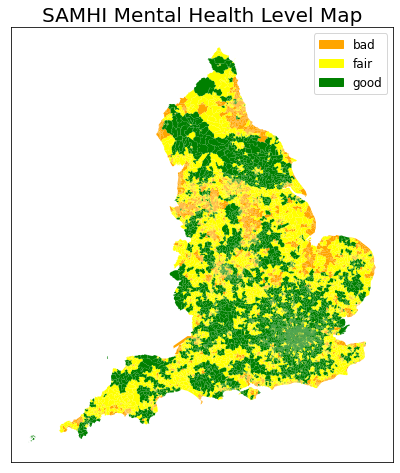

In [34]:
# Set the colors and labels for the mental health levels
colors = {'bad': 'orange', 'fair': 'yellow', 'good': 'green'}
labels = {'bad': 'Bad', 'fair': 'Fair', 'good': 'Good'}

# Create a figure and axis for the map
fig, ax = plt.subplots(1, figsize=(12, 8))

# Loop through each mental health level and plot the corresponding LSOAs
for level, color in colors.items():
    level_data = eng[eng['mental_health_level'] == level]
    level_data.plot(color=color, ax=ax)
    
# Create custom legend patches
legend_patches = [mpatches.Patch(color=color, label=label) for label, color in colors.items()]

# Set the title and legend
ax.set_title('SAMHI Mental Health Level Map', fontsize=20)
ax.legend(handles=legend_patches,fontsize=12)

# Remove the axis ticks and labels
ax.set_xticks([])
ax.set_yticks([])

plt.show()

### Train a Random Forest model for each mental health level

Training and evaluating model for good mental health level
Mean Squared Error: 0.10177595942708072
R-squared: 0.25509342514527866
Training and evaluating model for fair mental health level
Mean Squared Error: 0.05288115056954947
R-squared: 0.12972239496803406
Training and evaluating model for bad mental health level
Mean Squared Error: 0.24366946101929338
R-squared: 0.558701447735573


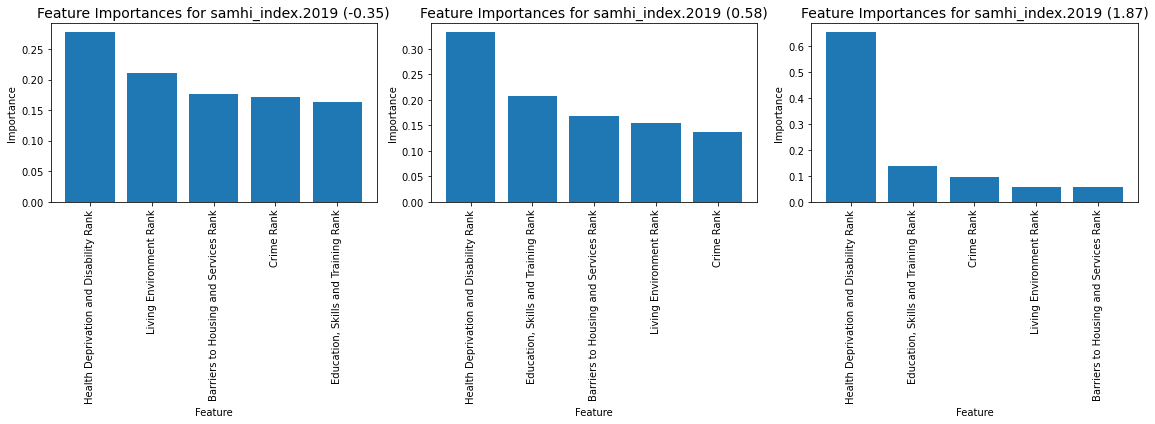

In [46]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Function to train a Random Forest model and display feature importances
def train_rf_and_evaluate(X, y, feature_names, ax):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
     # Define parameter grid for tuning
    param_grid = {
        'n_estimators': [50, 100, 150],
        'max_depth': [10,20,30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }
    
     # Create a Random Forest model
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_train, y_train)
    
     # Use GridSearchCV to tune the model with cross-validation
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
     # Train a model with the best parameters
    best_rf = grid_search.best_estimator_
    best_rf.fit(X_train, y_train)

     # Evaluate the model on the test set
    y_pred = best_rf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Squared Error: {mse}")
    print(f"R-squared: {r2}")

    importances = best_rf.feature_importances_
    sorted_indices = np.argsort(importances)[::-1]

    ax.bar(range(X.shape[1]), importances[sorted_indices], align='center')
    ax.set_xticks(range(X.shape[1]))
    ax.set_xticklabels(feature_names[sorted_indices], rotation=90)
    ax.set_xlabel('Feature')
    ax.set_ylabel('Importance')
    ax.set_title(f"Feature Importances for {y.name} ({y.mean():.2f})", fontsize=14)

    return best_rf
  

# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(16, 6))


# Train a Random Forest model for each mental health level
for i, level in enumerate(['good', 'fair', 'bad']):
    print(f"Training and evaluating model for {level} mental health level")
    level_data = eng[eng['mental_health_level'] == level]
    X = level_data[predictor_variables]
    y = level_data['samhi_index.2019']
    train_rf_and_evaluate(X, y, predictor_variables, axs[i])
    
plt.tight_layout()
plt.show()

Based on the results, it seems that the Random Forest model performs better for the "bad" mental health level compared to the "fair" and "good" mental health levels. The mean squared error is highest for the "bad" level (0.24) and lowest for the "fair" level (0.05). The R-squared value indicates that the model explains around 56% of the variance in the "bad" mental health level, 26% in the "good" level, and only 13% in the "fair" level. Overall, the results suggest that the model is better at predicting the "bad" mental health level compared to the other levels.

*```Good mental health level```: Health Deprivation and Disability Rank is also the most important feature with an importance score of over 0.25, followed by Living Environment Rank, which is higher than 0.2, and then Barriers to Housing and Services Rank, Crime Rank, and Education, Skills and Training Rank.

*```Fair mental health level```: Health Deprivation and Disability Rank is still the most important feature with an importance score of over 0.3, followed by Education, Skills and Training Rank, Barriers to Housing and Services Rank, Living Environment Rank, and Crime Rank, all with importance scores between 0.13-0.22.

*```Bad mental health level```: Health Deprivation and Disability Rank is the most important feature with importance score over 0.6, followed by Education, Skills and Training Rank, Crime Rank, Living Environment Rank, and Barriers to Housing and Services Rank, all with importance scores around 0.1.

The feature importances indicate the relative importance of each predictor variable in explaining the variation in the target variable (samhi_index.2019) for each mental health level. In this case, the reported feature importances for the samhi_index.2019 predictor variable are:

- Good mental health level: -0.35
- Fair mental health level: 0.58
- Bad mental health level: 1.87

These values suggest that the samhi_index.2019 variable is relatively more important for predicting the target variable (mental health level) for the bad mental health level, and less important for the fair and good mental health levels. The negative value for the good mental health level indicates that as the samhi_index.2019 variable decreases, the mental health level is predicted to increase.

<a id="ID_d&c"></a>
| [Intro](#ID_itr) | [Literature review](#ID_litr) | [Data](#ID_d) | [Analysis](#ID_an) | [Discussion and conclusion](#ID_d&c) | [Bibliography](#ID_bib) | [Appendix](#ID_app) |

## Discussion and conclusion

Based on the analysis conducted, several findings can be summarized regarding the mental health conditions in England:

- The spatial pattern of mental health levels across England shows that the southeast region has a higher proportion of LSOAs with good mental health levels, while the north and midlands regions have more LSOAs with bad mental health levels.

- The OLS regression results showed that several factors are statistically significant in determining the mental health index, including the Education, Skills and Training Rank, Health Deprivation and Disability Rank, Crime Rank, Barriers to Housing and Services Rank, and Living Environment Rank. Specifically, the negative coefficient of the Education, Skills and Training Rank indicates that higher education, skills and training are associated with better mental health outcomes. Meanwhile, the Health Deprivation and Disability Rank, Crime Rank, Barriers to Housing and Services Rank, and Living Environment Rank all have a positive coefficient, suggesting that higher deprivation, crime rates, and barriers to housing and services, and a poorer living environment are linked to worse mental health conditions.

- The Random Forest models trained for each mental health level provided insights into the importance of each predictor variable. One potential explanation for the consistently high importance of the Health Deprivation and Disability Rank in all three mental health levels is that health is a fundamental aspect of overall well-being. Poor physical health can often lead to a range of mental health issues, such as depression and anxiety, as well as increased stress levels. Furthermore, areas with higher levels of health deprivation and disability may also have fewer resources available for individuals to access mental health services and support, which can exacerbate existing mental health issues. the consistently high importance of the Health Deprivation and Disability Rank in all three mental health levels highlights the important role of physical health in overall well-being and mental health outcomes.

In terms of interpretation, the results suggest that socioeconomic and environmental factors play a significant role in determining mental health outcomes in England. People living in deprived areas with limited access to education, healthcare, and social services are more likely to experience poor mental health. Additionally, environmental factors such as poor living conditions, high crime rates, and limited access to housing can also contribute to poor mental health outcomes.

However, there are some limitations to this research. Firstly, the analysis is based solely on the available data, and other factors that may impact mental health outcomes, such as individual factors or cultural factors, were not considered. Secondly, the data used in this analysis is at the LSOA level, which may not accurately reflect the individual-level factors that contribute to mental health outcomes. Lastly, the analysis is cross-sectional and cannot establish a causal relationship between the predictor variables and mental health outcomes.

In conclusion, this analysis provides insights into the factors that contribute to mental health outcomes in England, highlighting the importance of socioeconomic and environmental factors. These findings can be useful for policymakers and public health professionals in developing strategies to improve mental health outcomes, particularly in areas with high levels of deprivation and limited access to social services. However, further research is needed to better understand the complex relationship between individual and cultural factors and mental health outcomes.

<a id="ID_bib"></a>
| [Intro](#ID_itr) | [Literature review](#ID_litr) | [Data](#ID_d) | [Analysis](#ID_an) | [Discussion and conclusion](#ID_d&c) | [Bibliography](#ID_bib) | [Appendix](#ID_app) |

## Bibiography

Fone, D., Greene, G., Farewell, D., White, J., Kelly, M. and Dunstan, F. (2013). ‘Common mental disorders, neighbourhood income inequality and income deprivation: small-area multilevel analysis’. The British Journal of Psychiatry. Cambridge University Press, 202 (4), pp. 286–293. doi: 10.1192/bjp.bp.112.116178.

Moscone, F. and Knapp, M. (2005). ‘Exploring the Spatial Pattern of Mental Health Expenditure’. J Ment Health Policy Econ.

Mylona, E., Kourou, K., Manikis, G., Kondylakis, H., Marias, K., Karademas, E., Poikonen-Saksela, P., Mazzocco, K., Marzorati, C., Pat-Horenczyk, R., Roziner, I., Sousa, B., Oliveira-Maia, A., Simos, P. and Fotiadis, D. I. (2021). ‘Prediction of Poor Mental Health Following Breast Cancer Diagnosis Using Random Forests1’. in 2021 43rd Annual International Conference of the IEEE Engineering in Medicine & Biology Society (EMBC). 2021 43rd Annual International Conference of the IEEE Engineering in Medicine & Biology Society (EMBC), pp. 1753–1756. doi: 10.1109/EMBC46164.2021.9629589.

Shatte, A. B. R., Hutchinson, D. M. and Teague, S. J. (2019). ‘Machine learning in mental health: a scoping review of methods and applications’. Psychological Medicine. Cambridge University Press, 49 (9), pp. 1426–1448. doi: 10.1017/S0033291719000151.

Yu, Y. and Williams, D. R. (1999). ‘Socioeconomic Status and Mental Health’. in Aneshensel, C. S. and Phelan, J. C. (eds) Handbook of the Sociology of Mental Health. Boston, MA: Springer US (Handbooks of Sociology and Social Research), pp. 151–166. doi: 10.1007/0-387-36223-1_8.

Zhou, Z.-H. (2021). Machine Learning. Springer Nature.

<a id="ID_app"></a>
| [Intro](#ID_itr) | [Literature review](#ID_litr) | [Data](#ID_d) | [Analysis](#ID_an) | [Discussion and conclusion](#ID_d&c) | [Bibliography](#ID_bib) | [Appendix](#ID_app) |

## Appendix

Link to the original raw data can be found here:
- [samhi version 4.00](https://pldr.org/dataset/2noyv/small-area-mental-health-index-samhi)
- [deprivatiaon File2](https://www.gov.uk/government/statistics/english-indices-of-deprivation-2019)
